# **Breast cancer detection**

This project aimed the detection of breast cancer using the [Breast Cancer Wisconsin (Original) Data Set](http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29).

For that purpose, a series of steps were followed:
1. Data cleansing
 - Correction of missing values
2. Data visualization and analysis
 - Principal Component Analysis (PCA) for data visualization
3. Model selection with hyperparameters tuning
 - Random Forest Classifier
 - Support Vector Machine
 - Logistic Regression
 - Voting Classifier with the previously tuned models (following a [Kaggle Kernel](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling))
4. Comparison between models and final observations
 
 
To solve this problem, the following Python packages were used:
 - Pandas
 - NumPy
 - Matplotlib and Seaborn
 - Scikit-learn

In [26]:
# Importing useful packages.

# Ignore Deprecation Warnings.
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

# Data handling.
import pandas as pd
import numpy as np

# Data visualization.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling.
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

### 1. Data cleansing
Firstly, the data was imported and stored in a data frame, using the Pandas package. The resulting data frame included 11 columns: 10 correspondent to features and 1 correspondent to the labels (Class).

In [27]:
df = pd.read_csv('Breast_Cancer_Data.txt')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
Id                        699 non-null int64
Clump_Thickness           699 non-null int64
Unif_Cell_Size            699 non-null int64
Unif_Cell_Shape           699 non-null int64
Marg_Adhesion             699 non-null int64
Single_Epith_Cell_Size    699 non-null int64
Bare_Nuclei               699 non-null object
Bland_Chrom               699 non-null int64
Norm_Nucleoli             699 non-null int64
Mitoses                   699 non-null int64
Class                     699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


All the features are numerical, except the Bare_Nuclei. As stated in the data set description, this feature has 3 missing values, marked with a '?'. To correct those values, the 0 value was used (since all the features are in a range of 1 to 10, it was still distinguished them). The column was then converted to numerical.

In [28]:
df.replace('?', 0, inplace = True)
df['Bare_Nuclei'] = df['Bare_Nuclei'].astype('int64')

In the original data set, the used labels are 2 to represent a benign tumor (negative class) and 4 to represent a malign tumor (positive class). Here, the labels were modified to use 0 as 'Benign' and 1 as 'Malign'.

In [29]:
df.loc[df['Class'] == 2 , 'Class'] = 0
df.loc[df['Class'] == 4 , 'Class'] = 1

### 2. Data visualization

During the data visualization step, it is possible to study how the features are related with each other and with the labels. With this step, more fundamented decisions can be made to achieved a better solution for the problem.

The 'Id' column was dropped since no relevant correlation was observed between the 'Id' feature and labels.

In [30]:
print('Correlation:', df['Id'].corr(df['Class']))
df.drop(['Id'], 1, inplace = True)

Correlation: -0.08022564705105643


In [31]:
df.head(5)

,Clump_Thickness,Unif_Cell_Size,Unif_Cell_Shape,Marg_Adhesion,Single_Epith_Cell_Size,Bare_Nuclei,Bland_Chrom,Norm_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


Analysing the 'Class' column, it was observed that 66% of the samples are associated with a benign tumor, whereas 34% are related with a malign tumor.

In [32]:
df['Class'].value_counts(normalize = True)

0    0.655222
1    0.344778
Name: Class, dtype: float64

For a better visualization of correlation between the data, the 'Class' column was moved to the first position of the data frame.

In [33]:
temp = pd.DataFrame(df['Class'])
df.drop(['Class'], 1, inplace = True)
df = pd.concat([temp, df], axis = 1)

The features exhibited a correlation with the labels ranging from 0.65 to 0.85 (roughly), except for the 'Mitoses' feature (0.42).
Since it was observed a correlation between all the features and the labels, all of them were used to solve the classification problem.

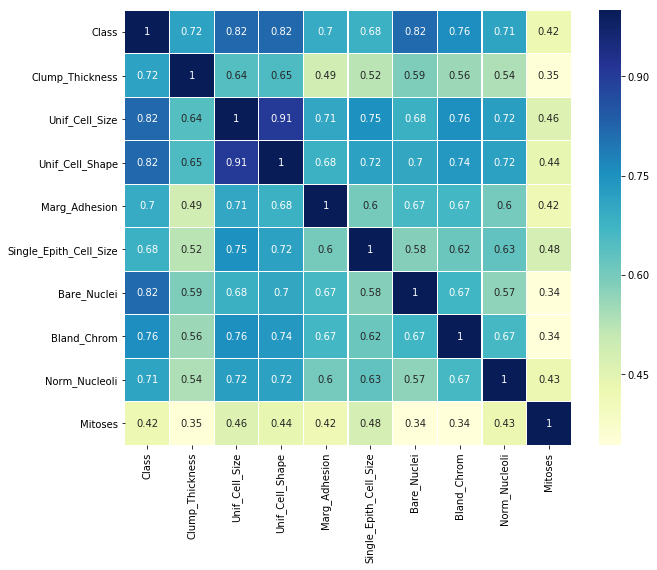

In [34]:
sns.heatmap(df.corr(), annot = True, cmap = 'YlGnBu', linewidths = 0.2)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

The data was represented using 9 features. In order to visualize the data, it had to be projected to a lower dimensional space. To obtain a 2-dimensional approximation of the data, it was applied the Principal Component Analysis (PCA) to the data. The Principal Components were then plotted.

The labels were dropped and PCA was applied afterwards.

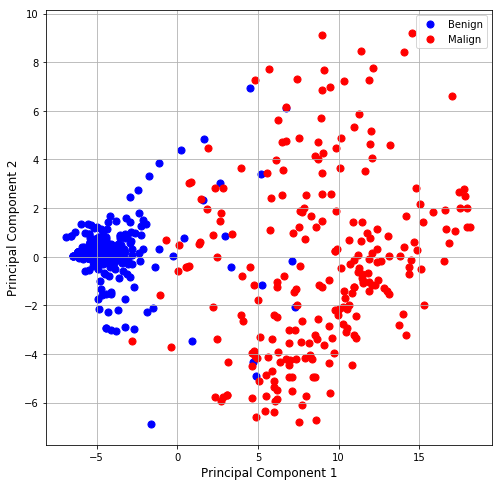

In [35]:
X = df.drop(['Class'], 1)

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])
principalDf_final = pd.concat([principalDf, df[['Class']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

labels = [0, 1]
colors = ['b', 'r']
for label, color in zip(labels, colors):
    indicesToKeep = principalDf_final.index[principalDf_final['Class'] == label]
    ax.scatter(principalDf_final.loc[indicesToKeep, 'Principal Component 1'],
               principalDf_final.loc[indicesToKeep, 'Principal Component 2'],
               c = color, s = 50)
    
ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.legend(['Benign', 'Malign'])
ax.grid()

The 2-D representation of the data showed that the 'Benign' class is essentially located on the left side of the plot and the 'Malign' class on the right side. However, in the middle of the plot there are mixed points correspondent to both the positive and negative classes.

### 3. Model selection and hyperparameters tuning

To solve this classification problem, three different classifiers were used: Random Forest Classifier, Support Vector Machine, and Logistic Regression, with the respective tuning of the hyperparameters using a stratified 10-fold cross validation. Finally, the three classifiers were ensembled in order to evaluate this method (for this situation).

First of all, it was assumed that all the features were categorical. For that reason, dummy columns were created, resulting in 90 different features.

In [36]:
def encode_and_dummies(df):
    df = pd.get_dummies(df, columns = ['Clump_Thickness'])
    df = pd.get_dummies(df, columns = ['Unif_Cell_Size'])
    df = pd.get_dummies(df, columns = ['Unif_Cell_Shape'])
    df = pd.get_dummies(df, columns = ['Marg_Adhesion'])
    df = pd.get_dummies(df, columns = ['Single_Epith_Cell_Size'])
    df = pd.get_dummies(df, columns = ['Bare_Nuclei'])
    df = pd.get_dummies(df, columns = ['Bland_Chrom'])
    df = pd.get_dummies(df, columns = ['Norm_Nucleoli'])
    df = pd.get_dummies(df, columns = ['Mitoses'])
    return df

df = encode_and_dummies(df)
df.head()

,Class,Clump_Thickness_1,Clump_Thickness_2,Clump_Thickness_3,Clump_Thickness_4,Clump_Thickness_5,Clump_Thickness_6,Clump_Thickness_7,Clump_Thickness_8,Clump_Thickness_9,...,Norm_Nucleoli_10,Mitoses_1,Mitoses_2,Mitoses_3,Mitoses_4,Mitoses_5,Mitoses_6,Mitoses_7,Mitoses_8,Mitoses_10
0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


It was then necessary to separate the features from the labels resulting in X and y, respectivelly. Afterwards, a training set and a test set were created. Note that to ensure the reproducibility of the results, a seed for the random number generator was set to 0.

In [37]:
column_names = list(df)

seed = 0

X = np.array(df.drop(['Class'], 1))
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (559, 90)
Test set shape: (140, 90)


For the tuning of the hyperparameters, a 10-fold stratified cross-validation was used to reduce the variance of the model. Besides that, since it was aimed the ensembling of the three classifiers, it was important to use the same folds during the hyperparameters tuning of each classifier.

However, the *k*-fold cross-validation comes at the expense of training the model *k* times more.

In [38]:
kfold = StratifiedKFold(n_splits = 10, random_state = seed)

The use of learning curves allows us to evaluate if our model is overfitting to the training set and also demonstrates the effect of the size of the training set in the accuracy of our model.

In [39]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean+train_scores_std,
                     alpha = 0.1, color = 'b')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean+test_scores_std, 
                     alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'b', label = 'Training accuracy')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Cross-validation accuracy')
    plt.legend(loc = 'best')
    
    return plt

#### Random Forest Classifier

The first classifier used was the [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). In order to optimize the hyperparameters for this classifier, it was used grid search. The hyperparameters to optimize were:
 - *max_features* - Number of features to consider when looking for the best split;
 - *min_samples_split* - Minimum number of samples required to split an internal node;
 - *min_samples_leaf* - Minimum number of samples required to be at a leaf node;
 - *n_estimators* - Number of trees in the forest;
 - *criterion* - Function to measure the quality of a split.
 
The parameter *class_weight* was set to "balanced" to consider the unbalance between the number of positive and negative examples.

In [40]:
RFC = RandomForestClassifier(class_weight = 'balanced', random_state = seed)

rf_param_grid = {'max_features': [1, 3, 6],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 3, 6],
              'n_estimators':[20, 50, 100, 400],
              'criterion': ['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold, return_train_score = True, n_jobs = -1, verbose = 1)
gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

print(gsRFC.best_score_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   54.5s finished


0.9731663685152058


The classifier seemed to be generalizing properly, since the training and cross-validation curves are close to each other.

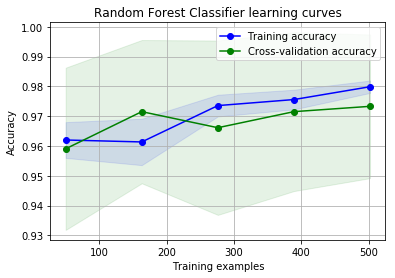

In [41]:
g = plot_learning_curve(gsRFC.best_estimator_, 'Random Forest Classifier learning curves', X_train, y_train, cv = kfold)

#### Support Vector Machine

The second classifier used was the [Support Vector Machine](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Once again, grid search was used for the hyperparameters optimization. The optimized hyperparameters were:
 - *C* - Regularization parameter;
 - *gamma* - Kernel coefficient;
 - *kernel* - Kernel type to use in the algorithm.
 
As in the Random Forest Classifier, the parameter *class_weight* was set to "balanced" to consider the unbalance between the number of positive and negative examples.

In [42]:
SVMC = SVC(probability = True, class_weight = 'balanced', random_state = seed)

svc_param_grid = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 5, 10, 20],
               'gamma': [1e-5, 3e-4, 1e-4, 3e-3, 1e-3, 3e-2, 1e-2, 3e-1, 1e-1, 1],
               'kernel': ['rbf', 'linear']}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = kfold, return_train_score = True, n_jobs= -1, verbose = 1)
gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

print(gsSVMC.best_score_)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   24.1s


0.9695885509838998


[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   33.0s finished


A proper generalization of this classifier could also be observed through the learning curves.

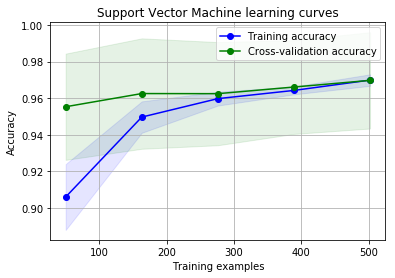

In [43]:
g = plot_learning_curve(gsSVMC.best_estimator_, 'Support Vector Machine learning curves', X_train, y_train, cv = kfold)

#### Logistic Regression

The last classifier used was [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). As in the remaining classifiers, it was used grid search for the hyperparameters optimization. For this classifier, the optimized hyperparameter was the regularization parameter, *C* (more specifically, the inverse of the regularization parameter).
 
To consider the unbalance between the number of positive and negative examples, the parameter *class_weight* was set to "balanced".

In [44]:
LG = LogisticRegression(class_weight = 'balanced', random_state = seed)

lg_param_grid = {'C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 5, 10]}

gsLG = GridSearchCV(LG, param_grid = lg_param_grid, cv = kfold, return_train_score = True, n_jobs= -1, verbose = 1)
gsLG.fit(X_train, y_train)

LG_best = gsLG.best_estimator_

print(gsLG.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


0.9695885509838998


Through the learning curves, it was possible to conclude that the Logistic Regression classifier was also generalizing properly.

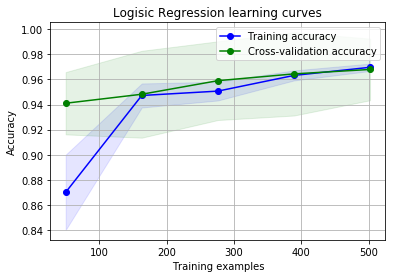

In [45]:
g = plot_learning_curve(gsLG.best_estimator_, 'Logisic Regression learning curves', X_train, y_train, cv = kfold)

#### Voting Classifier

Finally, it was used the [Voting Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) for the ensembling of the previously tuned classifiers.
 
First of all, it was important to study the correlation between the predictions from the different classifiers.

In [46]:
train_RFC = pd.Series(RFC_best.predict(X_train), name = 'RFC')
train_SVMC = pd.Series(SVMC_best.predict(X_train), name = 'SVM')
train_LG = pd.Series(gsLG.predict(X_train), name = 'LG')

test_RFC = pd.Series(RFC_best.predict(X_test), name = 'RFC')
test_SVMC = pd.Series(SVMC_best.predict(X_test), name = 'SVM')
test_LG = pd.Series(gsLG.predict(X_test), name = 'LG')

# Concatenate all classifier results in data frames.
X_train_results = pd.concat([train_RFC, train_SVMC, train_LG], axis = 1)
X_test_results = pd.concat([test_RFC, test_SVMC, test_LG], axis = 1)

The predictions for both the training and test sets were highly correlated between classifiers. Since there were not verified relevant differences between the classifiers, an ensembling method would not have a significant improvement in the results of the problem. However, the ensembling method was still implemented.

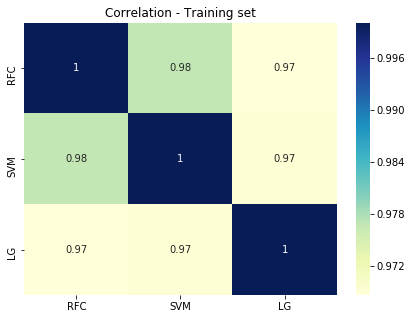

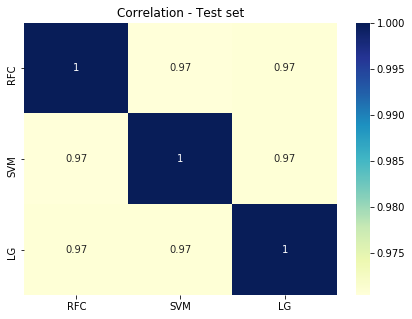

In [47]:
plt.figure(figsize = (7,5))
plt.title('Correlation - Training set')
g = sns.heatmap(X_train_results.corr(), cmap = 'YlGnBu', annot = True)

plt.figure(figsize = (7,5))
plt.title('Correlation - Test set')
g= sns.heatmap(X_test_results.corr(), cmap = 'YlGnBu', annot = True)

For the Voting Classifier, the previously tuned models were considered and the classifier was trained. A classification result of 97.86% on the test set was achieved using the Voting Classifier. The parameter *voting* was set to 'soft', meaning that the prediction of the label was based on the sum of the predicted probabilities from the individual classifiers.

In [48]:
votingC = VotingClassifier(estimators = [('rfc', RFC_best), ('svc', SVMC_best), ('lg', LG_best)], voting = 'soft', n_jobs = -1)
votingC = votingC.fit(X_train, y_train)

print(votingC.score(X_test, y_test))

0.9785714285714285


### 4. Comparison between models and final observations

It was of interest to compare the results obtained using the different models, for the test set.

In [49]:
final_RFC = pd.Series(RFC_best.score(X_test, y_test), name = 'Random Forest Classifier')
final_SVM = pd.Series(SVMC_best.score(X_test, y_test), name = 'Support Vector Machine')
final_LG = pd.Series(LG_best.score(X_test, y_test), name = 'Logistic Regression')
final_VC = pd.Series(votingC.score(X_test, y_test), name = 'Voting Classifier')

final = pd.concat([final_RFC, final_SVM, final_LG, final_VC], axis = 1)

final

,Random Forest Classifier,Support Vector Machine,Logistic Regression,Voting Classifier
0,0.971429,0.971429,0.971429,0.978571


Although the high correlation between the predictions from the different classifiers, a slight improvement on the accuracy was achieved when using the Voting Classifiers.

Finally, it was obtained a precision of 0.976 and a recall of 0.988.

In [50]:
conf_matrix = confusion_matrix(y_test, votingC.predict(X_test))
tp = conf_matrix[0][0]
fp = conf_matrix[0][1]
fn = conf_matrix[1][0]

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print('Precision:', precision)
print('Recall:', recall)

Precision: 0.9764705882352941
Recall: 0.9880952380952381


Although only the original features were used to solve this problem, the results obtained for the individual models and their ensembling are quite satisfatory.

The main objective behind this project was to apply techniques for data visualization and modeling, concretly the ensembling of classifiers which, in the end of day, had a minimal effect on the achieved results.